## Bachelor Thesis - Informatik

### Variante 2 :
### Multiclass-Klassifizierung mit 2D Convolutional Neuronal Network
***

<div align="left">
<h2><img src="https://i.giphy.com/media/v1.Y2lkPTc5MGI3NjExZ2hrOGtveWx0ZGxsaGFsYXNzbjVhOTNyaTg2cG44anZ5eWd5a3ZyMyZlcD12MV9pbnRlcm5hbF9naWZfYnlfaWQmY3Q9Zw/l3vRcrVqhBVSpJte0/giphy.gif" width="200" alt="Data"></h2>
</div>

Dieser Ansatz verwendet als Datengrundlage die folgenden drei Datensätze :

###### ☑️ Die Daten wurden von einem Myo-Armband per Bluetooth LE an einen ESP32S3 übertragen

###### ☑️ Sämtliche Daten wurden mit folgender Lösung [Processing-Grapher](https://github.com/chillibasket/processing-grapher.git) aufgezeichnet und als .csv-Datei gespeichert

###### ☑️ Vier Testpersonen, davon eine weibliche und drei männliche Personen standen zur Verfügung

###### ☑️ Alle Personen haben die folgenden vier Gesten in gleicher Position ausgeführt :

<img src="./Gestenbilder/Eigene_Geste_0.png" width="150">    <img src="./Gestenbilder/Eigene_Geste_1.png" width="150">    <img src="./Gestenbilder/Eigene_Geste_2.png" width="150">      <img src="./Gestenbilder/Eigene_Geste_3.png" width="150">

##### ▶️ Installation notwendiger Python-Bibliotheken
***

In [1]:
#%pip install pandas
#%pip install numpy
#%pip install seaborn
#%pip install -U seaborn-image
#%pip install matplotlib.pyplot
#%pip install scikit-learn
#%pip install tinymlgen

##### ▶️ Importieren notwendiger Python-Bibliotheken
***

In [2]:
import pandas as pd # type: ignore
import numpy as np # type: ignore
import seaborn as sns # type: ignore
import matplotlib.pyplot as plt # type: ignore

from sklearn.preprocessing import MinMaxScaler, StandardScaler # type: ignore
from sklearn.model_selection import train_test_split # type: ignore
from sklearn.metrics import classification_report, multilabel_confusion_matrix, confusion_matrix # type: ignore

import tensorflow as tf # type: ignore

from tensorflow import keras # type: ignore
from keras import layers # type: ignore
from keras import ops # type: ignore

##### ▶️ Einlesen der aufgezeichneten Daten aus dem Quellordner<br>
****


In [3]:
# Importiere die .csv-Dateien mit den EMG-Daten der einzelnen Probanden und den einzelnen Labels (Gesten)
# Dabei gilt folgendes Schema, siehe auch Bilder im Ordner "Gestenbilder"
# Label 0 --> Faust
# Label 1 --> Daumen hoch
# Label 2 --> Schere
# Label 3 --> Gespreizte Hand


##############################################################
# Aufnahme der Einzelgesten                                  #
# Datentyp: Python List                                      #
##############################################################
proband1 = []
proband2 = []
proband3 = []
proband4 = []

##############################################################
# Baue daraus den Dateipfad und lese Datei ein               #
# Schreibe Nummer der Geste in entsprechende Spalte          #
##############################################################

for label in ['0', '1', '2', '3']:
    proband1.append(pd.read_csv('./Elektromyografie-Daten/P1L' + label + '.csv', sep=',', header=None))        
    proband1[int(label)][64] = int(label)

for label in ['0', '1', '2', '3']:
    proband2.append(pd.read_csv('./Elektromyografie-Daten/P2L' + label + '.csv', sep=',', header=None))        
    proband2[int(label)][64] = int(label)

for label in ['0', '1', '2', '3']:
    proband3.append(pd.read_csv('./Elektromyografie-Daten/P3L' + label + '.csv', sep=',', header=None))        
    proband3[int(label)][64] = int(label)

for label in ['0', '1', '2', '3']:
    proband4.append(pd.read_csv('./Elektromyografie-Daten/P4L' + label + '.csv', sep=',', header=None))        
    proband4[int(label)][64] = int(label)


##############################################################
# Schreibe alle Sub-Dataframes in ein gesamtes Dataframe     #
# Datentyp: Pandas Dataframe                                 #
##############################################################
proband1 = pd.concat([df for df in proband1], axis=0).reset_index(drop=True)
proband2 = pd.concat([df for df in proband2], axis=0).reset_index(drop=True)
proband3 = pd.concat([df for df in proband3], axis=0).reset_index(drop=True)
proband4 = pd.concat([df for df in proband4], axis=0).reset_index(drop=True)

all_data = pd.concat([proband1, proband2, proband3, proband4])

##############################################################
# Schreibe alle Sub-Dataframes in ein gesamtes Dataframe     #
# Datentyp: Pandas Dataframe                                 #
##############################################################
all_data = all_data.dropna()
all_data

,0,1,2,3,4,5,6,7,8,9,...,55,56,57,58,59,60,61,62,63,64
0,8.0,-3.0,1.0,-2.0,-2.0,-3.0,8.0,-2.0,-5.0,-4.0,...,10.0,15.0,2.0,0.0,-4.0,-1.0,-9.0,-3.0,-3.0,0
1,12.0,-15.0,3.0,-4.0,-1.0,3.0,14.0,25.0,-42.0,2.0,...,3.0,-7.0,6.0,9.0,13.0,-1.0,6.0,-5.0,-6.0,0
2,2.0,0.0,5.0,3.0,-4.0,-3.0,1.0,26.0,-16.0,-7.0,...,3.0,-15.0,-11.0,-2.0,-4.0,-3.0,-10.0,-10.0,-5.0,0
3,4.0,-19.0,2.0,-2.0,-5.0,-8.0,-12.0,-9.0,-1.0,7.0,...,12.0,7.0,-1.0,-5.0,12.0,3.0,1.0,-2.0,-24.0,0
4,-4.0,-34.0,-6.0,-7.0,2.0,1.0,8.0,8.0,-6.0,9.0,...,-2.0,28.0,-14.0,-4.0,2.0,1.0,1.0,-11.0,-4.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1511,5.0,5.0,7.0,-1.0,1.0,0.0,0.0,-1.0,0.0,0.0,...,2.0,2.0,3.0,-9.0,-1.0,-1.0,-3.0,6.0,15.0,3
1512,-4.0,28.0,19.0,2.0,1.0,1.0,-1.0,0.0,0.0,-7.0,...,15.0,-3.0,1.0,2.0,2.0,-2.0,1.0,-7.0,-4.0,3
1513,2.0,-19.0,-18.0,1.0,-1.0,-3.0,-1.0,18.0,1.0,12.0,...,-3.0,3.0,-6.0,-5.0,-3.0,-1.0,0.0,2.0,-3.0,3
1514,-8.0,-6.0,-35.0,-1.0,-2.0,-2.0,0.0,-27.0,-7.0,-3.0,...,2.0,-4.0,-2.0,-8.0,4.0,1.0,2.0,-5.0,-8.0,3


##### ▶️ Umwandlung in geeignete Datenstrukturen
****
☑️ Erzeugte Strukturen haben das Format 16 x 64<br>
****


In [4]:
def split_dataframe(df, n, reminder = None):
    # Get number of rows in DataFrame
    total_rows = len(df)
    
    # Initialize list to hold the split DataFrames
    dfs = []
    
    # Calculate the number of DataFrames
    num_dfs = total_rows // n
    extra_rows = total_rows % n
    
    if reminder == 'first' and extra_rows > 0:
        # Size of first chunk is equal to reminder. Remaining chunks are same size.
        dfs.append(df.iloc[:n + extra_rows])
        start_idx = n + extra_rows
        for _ in range(1, num_dfs):
            dfs.append(df.iloc[start_idx:start_idx + n])
            start_idx += n
    elif reminder == 'last' and extra_rows > 0:
        # Last chunk consists of remining rows. The other chunks are the same size.
        for i in range(num_dfs):
            dfs.append(df.iloc[i*n:(i+1)*n])
        # Add extra rows to the last chunk
        dfs.append(df.iloc[num_dfs*n:])
    elif reminder == 'spread':
        # Evenly spread extra rows across the first few chunks
        for i in range(num_dfs + (1 if extra_rows > 0 else 0)):
            size = n + (1 if i < extra_rows else 0)
            dfs.append(df.iloc[i*size:min((i+1)*size, total_rows)])
    else:
        if extra_rows > 0:
            raise ValueError(f"DataFrame Länge ist nicht teilbar durch {n}. Bitte nutze den 'reminder' Parameter.")
        # If remainder is None and the DataFrame is perfectly divisible
        for i in range(num_dfs):
            dfs.append(df.iloc[i*n:(i+1)*n])
    
    return dfs


##############################################################
# Einzelwerte der Labels auslesen                            #
# Datentyp Pandas Dataframe                                  #
##############################################################
labels = all_data[all_data.columns[-1]]
 

##############################################################
# Klassen aus den Labels auslesen                            #
# Datentyp Numpy Array                                       #
##############################################################
classes = np.unique(labels)
print("Classes Shape:",classes.shape)


##############################################################
# Sensorwerte der Gesten auslesen                            #
# Datentyp Pandas Dataframe                                  #
##############################################################
features = all_data.drop(64, axis=1).copy()


##############################################################
# Zerteile Gesamtdaten in Einzelpakete mit jeweils 16 Zeilen #
# Datentyp Python List                                       #
##############################################################
features = split_dataframe(features, 4, 'last')
labels = split_dataframe(labels, 4, 'last')


##############################################################
# Entferne letztes Tupel aus Listen                          #
# Bei ungerader Anzahl Tupeln hat das letzte Listenelement   #
# eine abweichende Anzahl an Datenpunkten --> Problem        #
# Datentyp Python List                                       #
##############################################################
l_features = len(features)-1
features = features[:l_features]

l_labels = len(labels)-1
labels = labels[:l_labels]


##############################################################
# Konvertiere die Listen in Numpy-Arrays als Float32         #
# Dann eine Dimension hinzu als Channel                      #
# Datentyp Numpy-Array                                       #
##############################################################
features = np.array(features).astype('float32')
features = features.reshape(-1,64)

#sc = MinMaxScaler(feature_range=(-30,30))
#sc = MinMaxScaler()
#sc = StandardScaler()

#features = sc.fit_transform(features)

features = features.reshape(-1,4,64)

features = np.expand_dims(features, -1)


##############################################################
# Zuerst alle Label-Arrays nach 1D konvertieren              #
# Dann eine Dimension hinzu als Channel                      #
# Wichtig für das Convolution Neuronal Network !!            #
##############################################################
labels = np.array(labels).astype('int')
labels = labels[:,1]
labels = np.expand_dims(labels, -1)


##############################################################
# Gebe die Form des Image-Vectors aus                        #
##############################################################
print("Features Shape: ", features.shape)


##############################################################
# Gebe die Form des Label-Vectors aus                        #
##############################################################
print("Labels Shape:", labels.shape)
features

Classes Shape: (4,)
Features Shape:  (1515, 4, 64, 1)
Labels Shape: (1515, 1)


array([[[[  8.],
         [ -3.],
         [  1.],
         ...,
         [ -9.],
         [ -3.],
         [ -3.]],

        [[ 12.],
         [-15.],
         [  3.],
         ...,
         [  6.],
         [ -5.],
         [ -6.]],

        [[  2.],
         [  0.],
         [  5.],
         ...,
         [-10.],
         [-10.],
         [ -5.]],

        [[  4.],
         [-19.],
         [  2.],
         ...,
         [  1.],
         [ -2.],
         [-24.]]],


       [[[ -4.],
         [-34.],
         [ -6.],
         ...,
         [  1.],
         [-11.],
         [ -4.]],

        [[  3.],
         [ 13.],
         [  2.],
         ...,
         [ -3.],
         [  6.],
         [ 12.]],

        [[  5.],
         [  2.],
         [  4.],
         ...,
         [  7.],
         [ 11.],
         [ -1.]],

        [[ -7.],
         [ -5.],
         [  0.],
         ...,
         [  0.],
         [ -3.],
         [  5.]]],


       [[[ -1.],
         [  3.],
         [ -1.],
 

### ▶️ Datensatz aufteilen in Training- und Test-Daten
***

In [5]:
##############################################################
# Einkommentieren für den Kaggle-Datensatz                   #
# Fixwert 4                                                  #
##############################################################
num_classes = 4


##############################################################
# Fix 64 Sensorwerte pro Zeile --> (16, 64, 1)               #
##############################################################
input_shape = (4, 64, 1)


##############################################################
# Aufteilung der Datensätze in Training- und Testdaten       #
# Test-Size --> prozentualer Anteil von Gesamtdaten          #
# Random-State --> Zufallsgrad der Durchmischung             #
##############################################################
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size = 0.2, random_state = 100) # type: ignore
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.3, random_state=100)


##############################################################
# Status der Datensätze ausgeben                             #
##############################################################
print("X_train Vectorform:", X_train.shape)
print("X_test Vectorform:", X_test.shape)
print("X_validate Vectorform:", X_val.shape)
print("y_train Vectorform:", y_train.shape)
print("y_validate Vectorform:", y_val.shape)
print("y_test Vectorform:", y_test.shape)
print()
print(features.shape[0], "Gesamtwerte")
print(X_train.shape[0], "Trainingswerte")
print(X_test.shape[0], "Testwerte")


##############################################################
# Klassenvektor in Matrize konvertieren (One-Hot-Encoding)   #
##############################################################
y_train = keras.utils.to_categorical(y_train, num_classes)
y_val = keras.utils.to_categorical(y_val, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

X_train Vectorform: (848, 4, 64, 1)
X_test Vectorform: (303, 4, 64, 1)
X_validate Vectorform: (364, 4, 64, 1)
y_train Vectorform: (848, 1)
y_validate Vectorform: (364, 1)
y_test Vectorform: (303, 1)

1515 Gesamtwerte
848 Trainingswerte
303 Testwerte


#### ▶️ Modellarchitektur
***

In [6]:
##############################################################
# Hyperparameter                                             #
##############################################################
batch_size = 32
epochs = 16

initializer='glorot_uniform'
padding='same'

##############################################################
# Modell erstellen                                           #
##############################################################
model = keras.Sequential()
model.add(layers.InputLayer(input_shape))


model.add(layers.Conv2D(64, (2,2), strides=(2,2) ,padding = padding, activation='relu', input_shape=input_shape, kernel_initializer=initializer))
model.add(layers.MaxPool2D(1,1))

model.add(layers.Conv2D(64, (2,2), strides=(2,2) , padding = padding, activation='relu'))
model.add(layers.MaxPool2D(1,1))

model.add(layers.Reshape((-1,)))
model.add(layers.Dense(32, activation= 'relu'))

model.add(layers.Dense(num_classes, activation='softmax'))

# Modellparameter ausgeben
model.summary()

c:\Users\Gizmo\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 2, 32, 64)      │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 2, 32, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 1, 16, 64)      │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 1, 16, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │        32,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 49,700 (194.14 KB)

 Trainable params: 49,700 (194.14 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:
# Modell kompilieren
model.compile(
    optimizer='adam',
    loss = 'categorical_crossentropy',    
    metrics=['accuracy']
)

# Parameter und Daten an Modell übergeben
# Training durchführen
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    batch_size=batch_size,    
    epochs=epochs,
    callbacks=[
        tf.keras.callbacks.ReduceLROnPlateau(),        
    ]
)

Epoch 1/16
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.3628 - loss: 1.3429 - val_accuracy: 0.6538 - val_loss: 0.6835 - learning_rate: 0.0010
Epoch 2/16
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7445 - loss: 0.5408 - val_accuracy: 0.6566 - val_loss: 0.6269 - learning_rate: 0.0010
Epoch 3/16
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8476 - loss: 0.3534 - val_accuracy: 0.7665 - val_loss: 0.4996 - learning_rate: 0.0010
Epoch 4/16
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8954 - loss: 0.2420 - val_accuracy: 0.7830 - val_loss: 0.4642 - learning_rate: 0.0010
Epoch 5/16
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9454 - loss: 0.1595 - val_accuracy: 0.7885 - val_loss: 0.4701 - learning_rate: 0.0010
Epoch 6/16
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9786 - loss: 0.1166 - val_accuracy: 0.7912 - val_loss: 0.4766 - learning_rate: 0.0010
Epoch 7/16
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9805 - loss: 0.0849 - val_accuracy:

#### ▶️ Exportiere das Modell nach C++
***

In [8]:
"""
Export NN to C++
Copy-paste the generated code inside a file named model.h or irisModel.h
in your Arduino project
"""
from everywhereml.code_generators.tensorflow import convert_model

c_header = convert_model(model, X_train, y_train, model_name='FCNN')
print(c_header)


INFO:tensorflow:Assets written to: C:\Users\Gizmo\AppData\Local\Temp\tmpag5d2h3q\assets


INFO:tensorflow:Assets written to: C:\Users\Gizmo\AppData\Local\Temp\tmpag5d2h3q\assets


Saved artifact at 'C:\Users\Gizmo\AppData\Local\Temp\tmpag5d2h3q'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 4, 64, 1), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  1472919858128: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1472919859856: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1472919858512: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1472919860240: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1472919861968: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1472919862736: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1472919862160: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1472919851216: TensorSpec(shape=(), dtype=tf.resource, name=None)
#pragma once

#ifdef __has_attribute
#define HAVE_ATTRIBUTE(x) __has_attribute(x)
#else
#define HAVE_ATTRIBUTE(x) 0
#endif
#if HAVE_ATTRIBUTE(alig

### ▶️ Ausgabe der Funktionen für Verlust und Genauigkeit

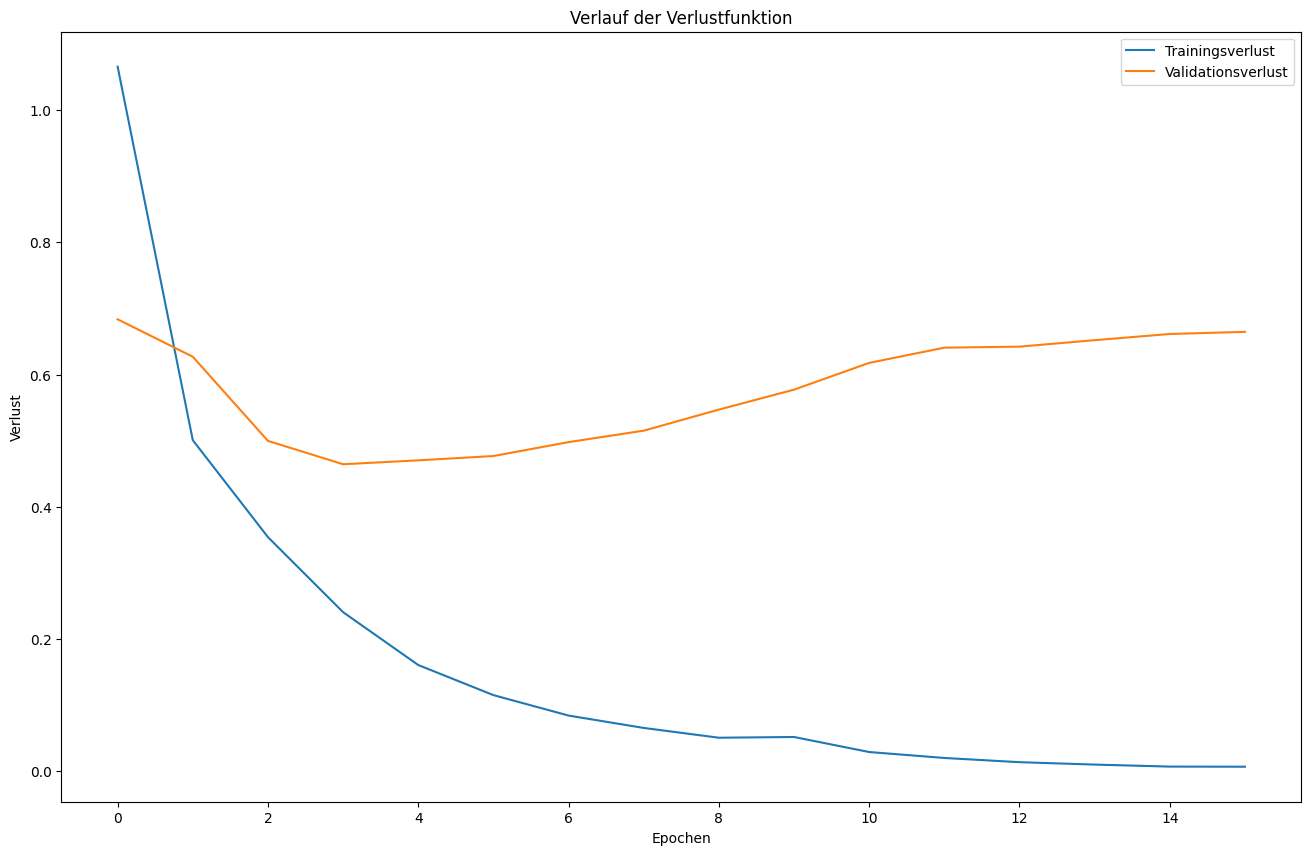

In [9]:
plt.figure(figsize=(16, 10))

plt.plot(range(epochs), history.history['loss'], label="Trainingsverlust")
plt.plot(range(epochs), history.history['val_loss'], label="Validationsverlust")

plt.xlabel("Epochen")
plt.ylabel("Verlust")
plt.legend()
plt.title("Verlauf der Verlustfunktion")

plt.show()

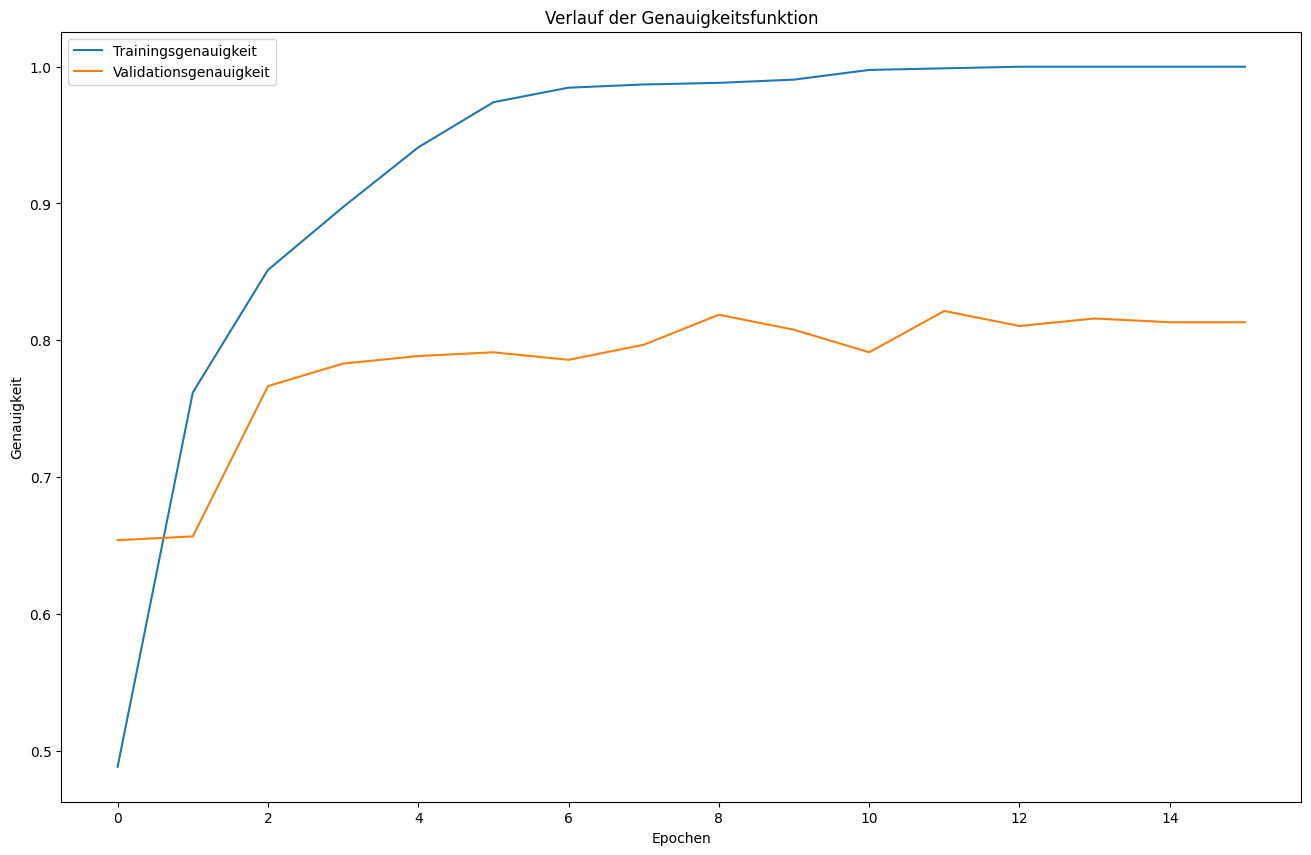

In [10]:
plt.figure(figsize=(16, 10))

plt.plot(range(epochs), history.history['accuracy'], label="Trainingsgenauigkeit")
plt.plot(range(epochs), history.history['val_accuracy'], label="Validationsgenauigkeit")

plt.xlabel("Epochen")
plt.ylabel("Genauigkeit")
plt.legend()
plt.title("Verlauf der Genauigkeitsfunktion")

plt.show()

### ▶️ Scores zur Beurteilung der Modellqualität 

In [11]:
score = model.evaluate(X_test, y_test, verbose=0)
print("Testverlust :", score[0])
print("Testgenauigkeit :", score[1])

Testverlust : 0.7280154824256897
Testgenauigkeit : 0.7953795194625854


In [12]:
y = model.predict(np.array(features))[49]
print("Es handelt sich um Geste : " + str(np.argmax(y)))

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Es handelt sich um Geste : 0


### ▶️ Metriken zur Beurteilung der Modellqualität 

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


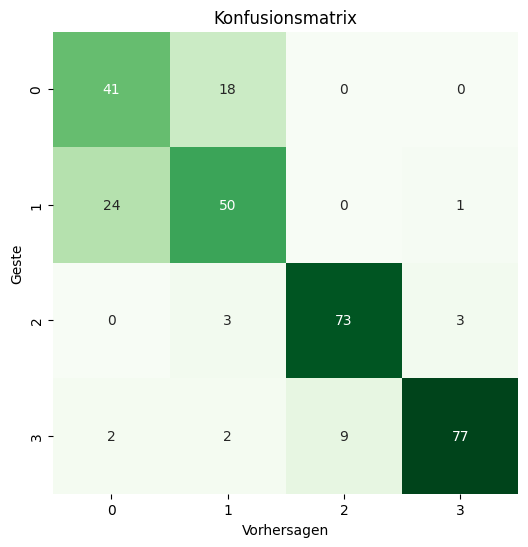

              precision    recall  f1-score   support

           0       0.61      0.69      0.65        59
           1       0.68      0.67      0.68        75
           2       0.89      0.92      0.91        79
           3       0.95      0.86      0.90        90

    accuracy                           0.80       303
   macro avg       0.78      0.79      0.78       303
weighted avg       0.80      0.80      0.80       303



In [13]:
X_test.shape

y_test_arg=np.argmax(y_test,axis=1)
y_pred = np.argmax(model.predict(X_test), axis=1)
 
cm = confusion_matrix(y_test_arg, y_pred)

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Greens', cbar=False)
plt.xlabel("Vorhersagen")
plt.ylabel("Geste")
plt.title("Konfusionsmatrix")
plt.show()

print(classification_report(y_test_arg, y_pred))
